## Elasticsearch performance tests

This is a simple notebook which evaluates time performance of elasticsearch requests using different document sizes and different requests. The following tests were run creating indexes and indexing data with sizes of 10K, 20K, 30K, 50K and 100K documents:
- Basic query "match_all" without filters.
- Geo shape filtered query.
- Geo shape filtered query with heatmap facetting.
- "match_all" query with heatmap facetting.

Tested with Elasticsearch 5.1.1 with heatmap plugin installed:
https://github.com/boundlessgeo/elasticsearch-heatmap/

## Functions definitions.

In [27]:
# Create elasticsearch connection.
import rawes
es = rawes.Elastic('http://localhost:9200')
global_query = {
    "query": {
        "match_all": {}
    }
}
geoshape_filter = {
  "bool": {
    "filter": {
      "geo_shape": {
        "layer_geoshape": {
          "shape": {
            "type": "envelope", 
            "coordinates": [
              ["-180.0", "90.0"], 
              ["180.0", "-90.0"]
            ]
          }, 
          "relation": "intersects"
        }
      }
    }
  }
}
heatmap_agg = {
  "viewport": {
    "heatmap": {
      "dist_err_pct": 0.07, 
      "field": "layer_geoshape", 
      "geom": {
        "geo_shape": {
          "layer_geoshape": {
            "shape": {
              "type": "envelope", 
              "coordinates": [
                ["-180.0", "90.0"], 
                ["180.0", "-90.0"]
              ]
            }, 
            "relation": "within"
          }
        }
      }
    }
  }
}

def p_hr():
    print "==============================================================="

def l_hr():
    print "---------------------------------------------------------------"    

In [28]:
def basic_query(index_name):
    query = global_query.copy()
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [29]:
def filtered_geoshape_query(index_name):
    query = global_query.copy()
    query['query'] = geoshape_filter
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [30]:
def heatmap_aggregation(index_name):    
    query = global_query.copy()
    query['query'] = geoshape_filter
    query['aggs'] = heatmap_agg
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [31]:
def heatmap_aggregation_nofilter(index_name):    
    query = global_query.copy()
    query['aggs'] = heatmap_agg
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [32]:
def test_performance(index_name):
    time_list = []
    p_hr()
    print "Test performance for %s" % (index_name)
    p_hr()
    
    print "\nBasic Query"
    l_hr()
    response = basic_query(index_name)
    print 'Total number of records: %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took'])    

    print "Geoshape filtering query"
    l_hr()
    response = filtered_geoshape_query(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took']) 

    print "Heatmap aggregation query"
    l_hr()
    response = heatmap_aggregation(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took'])

    print "Heatmap aggregation without filter query"
    l_hr()
    response = heatmap_aggregation_nofilter(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs' % response['took']
    time_list.append(response['took'])
    
    return time_list

### 1. Experiments with 10k documents

#### a. Create and index documents with mapping...using bash

In [33]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_10k -d @mapping.json
print '\nIndexing documents...'
!time curl --silent -XPOST http://localhost:9200/index_10k/layer/_bulk --data-binary @data_es/scroll_0001.json > /dev/null
times_10k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m15.566s
user	0m0.014s
sys	0m0.062s


{u'_shards': {u'failed': 0, u'successful': 5, u'total': 10}}

#### b. Test performance

In [34]:
time_10k = test_performance('index_10k')

Test performance for index_10k

Basic Query
---------------------------------------------------------------
Total number of records: 10000
Response time 115 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 10000
Response time 80 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 10000
Response time 219 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 10000
Response time 56 msecs


### 2. Experiments with 20k documents

#### a. Create and index documents with mapping...using bash

In [35]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_20k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 2 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_20k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_20k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m28.593s
user	0m0.033s
sys	0m0.125s


{u'_shards': {u'failed': 0, u'successful': 10, u'total': 20}}

#### b. Test performance

In [36]:
time_20k = test_performance('index_20k')

Test performance for index_20k

Basic Query
---------------------------------------------------------------
Total number of records: 20000
Response time 40 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 20000
Response time 73 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 20000
Response time 175 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 20000
Response time 254 msecs


### 3. Experiments with 30k documents

#### a. Create and index documents with mapping...using bash

In [37]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_30k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 3 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_30k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_30k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m39.287s
user	0m0.054s
sys	0m0.210s


{u'_shards': {u'failed': 0, u'successful': 15, u'total': 30}}

#### b. Test performance

In [38]:
time_30k = test_performance('index_30k')

Test performance for index_30k

Basic Query
---------------------------------------------------------------
Total number of records: 30000
Response time 15 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 30000
Response time 35 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 30000
Response time 75 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 30000
Response time 104 msecs


### 4. Experiments with 50k documents

#### a. Create and index documents with mapping...using bash

In [39]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_50k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 5 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_50k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_50k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m48.257s
user	0m0.074s
sys	0m0.274s


{u'_shards': {u'failed': 0, u'successful': 20, u'total': 40}}

#### b. Test performance

In [40]:
time_50k = test_performance('index_50k')

Test performance for index_50k

Basic Query
---------------------------------------------------------------
Total number of records: 50000
Response time 27 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 50000
Response time 57 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 50000
Response time 195 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 50000
Response time 161 msecs


### 5. Experiments with 100k documents

#### a. Create and index documents with mapping...using bash

In [41]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_100k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 10 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_100k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_100k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	1m50.855s
user	0m0.159s
sys	0m0.592s


{u'_shards': {u'failed': 0, u'successful': 25, u'total': 50}}

#### b. Test performance

In [42]:
time_100k = test_performance('index_100k')

Test performance for index_100k

Basic Query
---------------------------------------------------------------
Total number of records: 100000
Response time 32 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 100000
Response time 29 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 100000
Response time 251 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 100000
Response time 163 msecs


Populating the interactive namespace from numpy and matplotlib


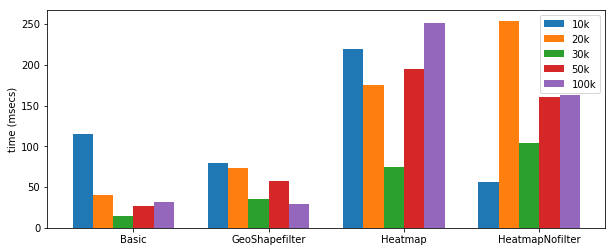

In [43]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

import numpy as np
from matplotlib import pyplot as plt

N = 4
ind = np.arange(N)
width = 0.15
fig, ax = plt.subplots()
rects_10k = ax.bar(ind, time_10k, width)
rects_20k = ax.bar(ind + width, time_20k, width)
rects_30k = ax.bar(ind + 2*width, time_30k, width)
rects_50k = ax.bar(ind + 3*width, time_50k, width)
rects_100k = ax.bar(ind + 4*width, time_100k, width)

ax.set_ylabel('time (msecs)')
ax.set_xticks(ind + 2.5*width)
ax.set_xticklabels(('Basic', 'GeoShapefilter', 'Heatmap', 'HeatmapNofilter'))

legend_tuple = (rects_10k[0], rects_20k[0], rects_30k[0], rects_50k[0], rects_100k[0])
legend_names = ('10k', '20k', '30k', '50k', '100k')
ax.legend(legend_tuple, legend_names)


plt.show()